In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import os
import joblib
import xgboost as xgb
from xgboost.callback import EarlyStopping
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.metrics import (
    precision_score, recall_score, f1_score, classification_report,
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score,
    confusion_matrix, ConfusionMatrixDisplay
)
from imblearn.over_sampling import SMOTENC
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from xgboost import XGBClassifier


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("xiaojiu1414/digix-global-ai-challenge")

print("Path to dataset files:", path)

100%|██████████| 879M/879M [00:05<00:00, 168MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/xiaojiu1414/digix-global-ai-challenge/versions/1


In [ ]:
train_ads = pd.read_csv(os.path.join(path, "train", "train_data_ads.csv"))

In [ ]:
train_ads['pt_d'] = pd.to_datetime(train_ads['pt_d'], format='%Y%m%d%H%M')
train_ads = train_ads.sort_values('pt_d').reset_index(drop=True)

In [ ]:
# Target column
target = 'label'

# Numeric features
numeric_features = ['app_score', 'u_refreshTimes']

# Categorical features (integer codes)
categorical_features = [
    'gender','age','residence','city','city_rank','series_dev','series_group',
    'emui_dev','device_name','device_size','net_type','task_id','adv_id',
    'creat_type_cd','adv_prim_id','inter_type_cd','slot_id','site_id',
    'spread_app_id','hispace_app_tags','app_second_class','u_feedLifeCycle'
]

# List-like string features: we convert to simple counts
list_features = [
    'ad_click_list_v001','ad_click_list_v002','ad_click_list_v003',
    'ad_close_list_v001','ad_close_list_v002','ad_close_list_v003',
    'u_newsCatInterestsST'
]

In [ ]:
ads = train_ads.copy()

def count_caret_entries(series):
    return series.fillna('').apply(
        lambda x: len([t for t in str(x).split('^') if t])
    )

# Create count columns
for col in list_features:
    ads[f'{col}_count'] = count_caret_entries(ads[col])

ads = ads.drop(columns=list_features)
numeric_features.extend([f'{col}_count' for col in list_features])

# Aggregate correlated features
ads['click_count_mean'] = ads[['ad_click_list_v001_count',
                               'ad_click_list_v002_count',
                               'ad_click_list_v003_count']].mean(axis=1)

ads['close_count_mean'] = ads[['ad_close_list_v001_count',
                               'ad_close_list_v002_count',
                               'ad_close_list_v003_count']].mean(axis=1)

ads = ads.drop(columns=[
    'ad_click_list_v001_count','ad_click_list_v002_count','ad_click_list_v003_count',
    'ad_close_list_v001_count','ad_close_list_v002_count','ad_close_list_v003_count'
])

data pruning

In [ ]:
# 1. Original CTR on full (feature-engineered) dataset
ctr_original = ads[target].mean()
print(f"Original click-through rate (full data): {ctr_original:.4%}")

# 2. Find users with at least one positive label
#    If your user ID column is not 'uid', change this name.
clicked_users = ads.loc[ads[target] == 1, "user_id"].unique()

print(f"Total users before pruning: {ads['user_id'].nunique():,}")
print(f"Users with ≥1 click:        {len(clicked_users):,}")

# 3. Keep only rows from those users
ads_pruned = ads[ads["user_id"].isin(clicked_users)].copy()

# 4. CTR after pruning
ctr_pruned = ads_pruned[target].mean()
print(f"Pruned click-through rate (only clickers): {ctr_pruned:.4%}")

print(f"Rows before pruning: {len(ads):,}")
print(f"Rows after pruning:  {len(ads_pruned):,}")

# 5. From here on, overwrite `ads` and rebuild X, y
ads = ads_pruned

# Prepare data for models (this matches your original pattern)
X = ads[numeric_features + categorical_features]
y = ads[target]

Original click-through rate (full data): 1.5522%
Total users before pruning: 65,297
Users with ≥1 click:        61,777
Pruned click-through rate (only clickers): 1.6178%
Rows before pruning: 7,675,517
Rows after pruning:  7,363,912


In [ ]:
numeric_features = ['app_score','u_refreshTimes','click_count_mean','close_count_mean','u_newsCatInterestsST_count']

# Prepare data
X = ads[numeric_features + categorical_features]
y = ads[target]

In [ ]:
X.head(10)

,app_score,u_refreshTimes,click_count_mean,close_count_mean,u_newsCatInterestsST_count,gender,age,residence,city,city_rank,...,adv_id,creat_type_cd,adv_prim_id,inter_type_cd,slot_id,site_id,spread_app_id,hispace_app_tags,app_second_class,u_feedLifeCycle
0,10.0,4,1.000000,1.0,5,2,7,17,215,4,...,21517,8,1490,4,35,1,306,27,14,17
1,10.0,5,3.666667,1.0,5,2,8,24,431,5,...,21695,8,1036,4,22,1,312,43,18,17
2,0.0,0,4.333333,1.0,5,2,8,25,117,2,...,13144,5,1944,3,40,1,213,18,23,16
3,10.0,8,5.000000,1.0,5,2,7,37,312,2,...,14143,8,1669,4,42,1,344,20,13,17
4,10.0,2,4.000000,1.0,1,2,3,11,415,2,...,22701,8,1106,5,54,1,240,12,29,11
5,10.0,2,4.000000,1.0,1,2,3,11,415,2,...,11687,8,1068,5,26,1,190,47,14,11
6,0.0,0,1.000000,1.0,1,2,2,13,191,4,...,10858,5,1466,3,54,1,213,18,23,11
7,10.0,0,2.000000,1.0,5,2,5,16,212,5,...,10945,8,1220,4,34,1,280,49,17,17
8,10.0,0,2.000000,1.0,5,2,5,16,212,5,...,12359,8,1142,4,63,1,240,12,29,17
9,0.0,9,3.666667,1.0,5,2,2,37,173,4,...,11292,7,1097,3,54,1,213,18,23,17


try xg boost undersample

STEP 1: Sampling 200k rows from full dataset
Sample size: 200,000
Class 0: 196,896 (98.45%)
Class 1: 3,104 (1.55%)

STEP 2: Encoding categorical variables
Encoded 22 categorical variables

STEP 3: Train/Test split
Train size: 160,000
Test size: 40,000
Test distribution: Class 0=39,379, Class 1=621

STEP 4: Undersample training data
Training before: Class 0=157,517, Class 1=2,483
Training after: Class 0=12,415, Class 1=2,483
Training ratio: 5.0:1

STEP 5: Calculating scale_pos_weight
scale_pos_weight: 63.4

STEP 6: Training XGBoost with DEFAULT parameters
Using XGBoost DEFAULTS:
  learning_rate=0.3 (default)
  subsample=1.0 (default)
[0]	validation_0-logloss:1.57261


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [02:51:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[50]	validation_0-logloss:1.46282
[100]	validation_0-logloss:1.30326
[150]	validation_0-logloss:1.18248
[200]	validation_0-logloss:1.08871
[250]	validation_0-logloss:1.01103
[300]	validation_0-logloss:0.94760
[350]	validation_0-logloss:0.91190
[399]	validation_0-logloss:0.89615
Training completed in 1.9 seconds

STEP 7: Generating predictions

STEP 8: Finding optimal threshold
Optimal threshold: 0.988

STEP 9: Results with threshold=0.5 (FIXED)

 RESULTS WITH THRESHOLD=0.5:
Precision: 0.0273
Recall: 0.7488
F1 Score: 0.0526
ROC-AUC: 0.7388
PR-AUC: 0.0830

 CLASSIFICATION REPORT (threshold=0.5):
              precision    recall  f1-score   support

           0       0.99      0.58      0.73     39379
           1       0.03      0.75      0.05       621

    accuracy                           0.58     40000
   macro avg       0.51      0.66      0.39     40000
weighted avg       0.98      0.58      0.72     40000


 CONFUSION MATRIX (threshold=0.5):
          Pred 0  Pred 1
Actual 0   

/tmp/ipython-input-1939028015.py:150: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision_curve * recall_curve) / (precision_curve + recall_curve)


          Pred 0  Pred 1
Actual 0   38738     641
Actual 1     511     110

🔝 TOP 20 MOST IMPORTANT FEATURES:
                   feature  importance
            u_refreshTimes    0.082457
             creat_type_cd    0.070240
u_newsCatInterestsST_count    0.067268
                   slot_id    0.064742
           u_feedLifeCycle    0.049161
                       age    0.040194
                series_dev    0.037804
              series_group    0.037434
                  net_type    0.036253
          hispace_app_tags    0.035154
          click_count_mean    0.033677
                      city    0.033225
          close_count_mean    0.033064
                    gender    0.032152
               device_name    0.031968
          app_second_class    0.031460
             spread_app_id    0.030699
               device_size    0.030348
                 residence    0.030227
                 app_score    0.030083

STEP 12: Visualizing top 10 most important features


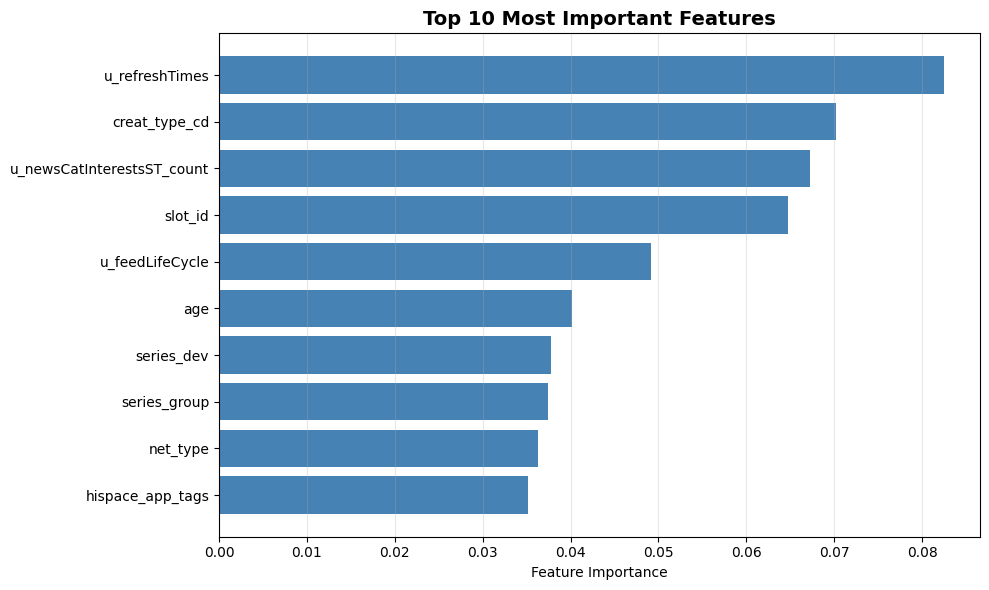


STEP 13: Generating ROC and PR Curves


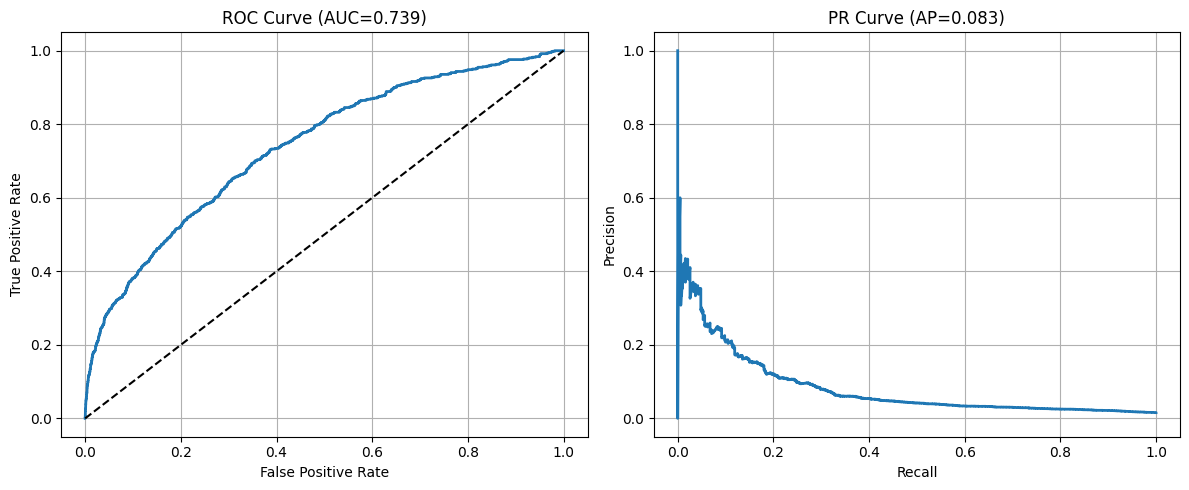


 Complete!


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    precision_score, recall_score, f1_score, classification_report,
    confusion_matrix, roc_auc_score, average_precision_score, precision_recall_curve
)
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ============================================================================
# STEP 1: Sample 200k from full dataset
# ============================================================================
print("="*80)
print("STEP 1: Sampling 200k rows from full dataset")
print("="*80)

N = 200_000
if len(ads) > N:
    X_sample, _, y_sample, _ = train_test_split(
        X, y, train_size=N, stratify=y, random_state=42
    )
else:
    X_sample, y_sample = X, y

print(f"Sample size: {len(X_sample):,}")
print(f"Class 0: {sum(y_sample == 0):,} ({100*sum(y_sample == 0)/len(y_sample):.2f}%)")
print(f"Class 1: {sum(y_sample == 1):,} ({100*sum(y_sample == 1)/len(y_sample):.2f}%)")

# ============================================================================
# STEP 2: Encode categorical variables
# ============================================================================
print("\n" + "="*80)
print("STEP 2: Encoding categorical variables")
print("="*80)

X_encoded = X_sample.copy()
encoders = {}

for col in categorical_features:
    le = LabelEncoder()
    le.fit(X_sample[col].astype(str))
    encoders[col] = le
    X_encoded[col] = le.transform(X_sample[col].astype(str))

print(f"Encoded {len(categorical_features)} categorical variables")

# ============================================================================
# STEP 3: Train/Test split
# ============================================================================
print("\n" + "="*80)
print("STEP 3: Train/Test split")
print("="*80)

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_sample, test_size=0.2, stratify=y_sample, random_state=42
)

print(f"Train size: {len(X_train):,}")
print(f"Test size: {len(X_test):,}")
print(f"Test distribution: Class 0={sum(y_test == 0):,}, Class 1={sum(y_test == 1):,}")

# ============================================================================
# STEP 4: Undersample ONLY training data
# ============================================================================
print("\n" + "="*80)
print("STEP 4: Undersample training data")
print("="*80)

X_pos = X_train[y_train == 1]
X_neg = X_train[y_train == 0]
y_pos = y_train[y_train == 1]
y_neg = y_train[y_train == 0]

target_ratio = 5.0
n_neg_samples = int(len(X_pos) * target_ratio)

X_neg_sample = X_neg.sample(n=n_neg_samples, random_state=42)
y_neg_sample = y_neg[X_neg_sample.index]

X_train_balanced = pd.concat([X_pos, X_neg_sample]).reset_index(drop=True)
y_train_balanced = pd.concat([y_pos, y_neg_sample]).reset_index(drop=True)

print(f"Training before: Class 0={len(X_neg):,}, Class 1={len(X_pos):,}")
print(f"Training after: Class 0={len(X_neg_sample):,}, Class 1={len(X_pos):,}")
print(f"Training ratio: {sum(y_train_balanced == 0)/sum(y_train_balanced == 1):.1f}:1")

# ============================================================================
# STEP 5: Calculate scale_pos_weight
# ============================================================================
print("\n" + "="*80)
print("STEP 5: Calculating scale_pos_weight")
print("="*80)

pos_count = sum(y_train == 1)
neg_count = sum(y_train == 0)
scale_pos_weight = neg_count / pos_count

print(f"scale_pos_weight: {scale_pos_weight:.1f}")

# ============================================================================
# STEP 6: Train XGBoost with DEFAULT parameters
# ============================================================================
print("\n" + "="*80)
print("STEP 6: Training XGBoost with DEFAULT parameters")
print("="*80)

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_balanced, y_train_balanced, test_size=0.1, stratify=y_train_balanced, random_state=42
)

print("Using XGBoost DEFAULTS:")
print("  learning_rate=0.3 (default)")
print("  subsample=1.0 (default)")

xgb_model = xgb.XGBClassifier(
    n_estimators=400,              # Use more trees with early stopping
    max_depth=4,                    # Moderate depth to avoid overfitting
    gamma=1.0,                      # Minimum gain to split
    colsample_bytree=0.7,           # Subsample features
    scale_pos_weight=scale_pos_weight,  # Set to ratio of negative / positive in training data
    random_state=42,
    use_label_encoder=False,
    early_stopping_rounds=50
)

import time
start = time.time()
xgb_model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=50)
print(f"Training completed in {time.time() - start:.1f} seconds")

# ============================================================================
# STEP 7: Predict probabilities
# ============================================================================
print("\n" + "="*80)
print("STEP 7: Generating predictions")
print("="*80)

y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

# ============================================================================
# STEP 8: Find optimal threshold
# ============================================================================
print("\n" + "="*80)
print("STEP 8: Finding optimal threshold")
print("="*80)

precision_curve, recall_curve, thresh_curve = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (precision_curve * recall_curve) / (precision_curve + recall_curve)
f1_scores = np.nan_to_num(f1_scores)
best_threshold = thresh_curve[np.argmax(f1_scores)]

print(f"Optimal threshold: {best_threshold:.3f}")

# ============================================================================
# STEP 9: Evaluate with THRESHOLD = 0.5
# ============================================================================
print("\n" + "="*80)
print("STEP 9: Results with threshold=0.5 (FIXED)")
print("="*80)

y_pred_default = (y_pred_proba >= 0.5).astype(int)

print(f"\n RESULTS WITH THRESHOLD=0.5:")
print(f"Precision: {precision_score(y_test, y_pred_default):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_default):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_default):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f"PR-AUC: {average_precision_score(y_test, y_pred_proba):.4f}")

print("\n CLASSIFICATION REPORT (threshold=0.5):")
print("="*80)
print(classification_report(y_test, y_pred_default))

print("\n CONFUSION MATRIX (threshold=0.5):")
cm_default = confusion_matrix(y_test, y_pred_default, labels=[0, 1])
cm_df_default = pd.DataFrame(cm_default,
                      index=['Actual 0', 'Actual 1'],
                      columns=['Pred 0', 'Pred 1'])
print(cm_df_default)

# ============================================================================
# STEP 10: Evaluate with OPTIMAL threshold
# ============================================================================
print("\n" + "="*80)
print("STEP 10: Results with optimal threshold")
print("="*80)

y_pred_optimal = (y_pred_proba >= best_threshold).astype(int)

print(f"\n RESULTS WITH OPTIMAL THRESHOLD ({best_threshold:.3f}):")
print(f"Precision: {precision_score(y_test, y_pred_optimal):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_optimal):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_optimal):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f"PR-AUC: {average_precision_score(y_test, y_pred_proba):.4f}")

print("\n CLASSIFICATION REPORT (optimal threshold):")
print("="*80)
print(classification_report(y_test, y_pred_optimal))

print("\n CONFUSION MATRIX (optimal threshold):")
cm_optimal = confusion_matrix(y_test, y_pred_optimal, labels=[0, 1])
cm_df_optimal = pd.DataFrame(cm_optimal,
                      index=['Actual 0', 'Actual 1'],
                      columns=['Pred 0', 'Pred 1'])
print(cm_df_optimal)

# ============================================================================
# STEP 11: Feature importance
# ============================================================================
print("\n🔝 TOP 20 MOST IMPORTANT FEATURES:")
print("="*80)
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.head(20)[['feature', 'importance']].to_string(index=False))

# ============================================================================
# STEP 12: Visualization - Feature Importance Bar Chart
# ============================================================================
print("\n" + "="*80)
print("STEP 12: Visualizing top 10 most important features")
print("="*80)

fig, axes = plt.subplots(1, 1, figsize=(10, 6))

top_10 = feature_importance.head(10)
axes.barh(range(len(top_10)), top_10['importance'], color='steelblue')
axes.set_yticks(range(len(top_10)))
axes.set_yticklabels(top_10['feature'])
axes.invert_yaxis()  # Top feature at the top
axes.set_xlabel('Feature Importance')
axes.set_title('Top 10 Most Important Features', fontsize=14, fontweight='bold')
axes.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# STEP 13: Visualization - ROC and PR Curves
# ============================================================================
print("\n" + "="*80)
print("STEP 13: Generating ROC and PR Curves")
print("="*80)

from sklearn.metrics import roc_curve

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
axes[0].plot(fpr, tpr, lw=2)
axes[0].plot([0, 1], [0, 1], 'k--')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title(f'ROC Curve (AUC={roc_auc_score(y_test, y_pred_proba):.3f})')
axes[0].grid(True)

# PR Curve
axes[1].plot(recall_curve, precision_curve, lw=2)
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title(f'PR Curve (AP={average_precision_score(y_test, y_pred_proba):.3f})')
axes[1].grid(True)

plt.tight_layout()
plt.show()

print("\n Complete!")

try with smotenc and no scale pos

STEP 1: Sampling 200k rows from full dataset
Sample size: 200,000
Class 0: 196,896 (98.45%)
Class 1: 3,104 (1.55%)

STEP 2: Encoding categorical variables
Encoded 22 categorical variables

STEP 3: Train/Test split
Train size: 160,000
Test size: 40,000

STEP 4: Undersample training data
Before SMOTENC: Class 0=12,415, Class 1=2,483

STEP 5: Standardizing numeric features for SMOTENC
 Numeric features standardized

STEP 6: Applying SMOTENC
 Applying SMOTENC (this may take 2-5 minutes)...
After SMOTENC: Class 0=12,415, Class 1=12,415
 SMOTENC created 9,932 synthetic samples
Balanced to 1:1 ratio!

STEP 7: Training XGBoost with DEFAULT parameters
Using XGBoost DEFAULTS:
  learning_rate=0.1
  max_depth=4
  n_estimators=400
  subsample=1.0
  colsample_bytree=0.7
  gamma=2.5
  NO scale_pos_weight
[0]	validation_0-logloss:0.67033
[50]	validation_0-logloss:0.40260
[100]	validation_0-logloss:0.35691
[150]	validation_0-logloss:0.33462
[180]	validation_0-logloss:0.33462
Training completed in 0.4 s

/tmp/ipython-input-1948062856.py:166: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision_curve * recall_curve) / (precision_curve + recall_curve)


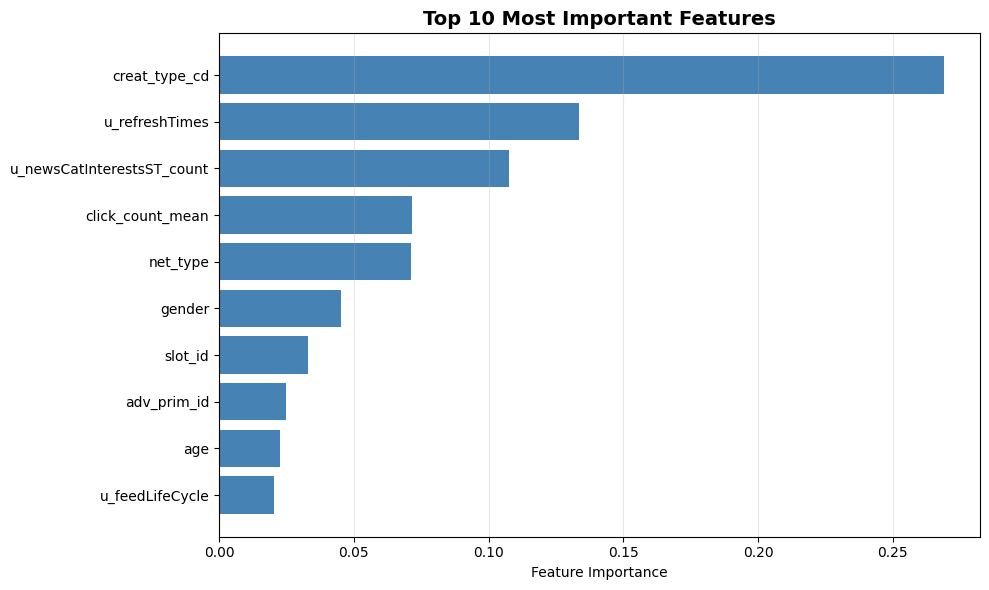


STEP 14: Generating ROC and PR Curves


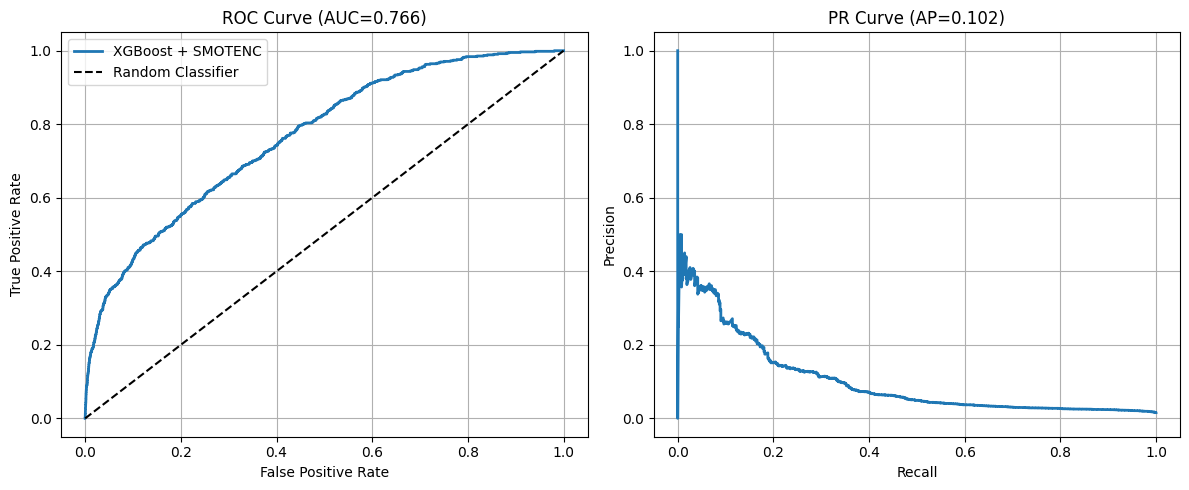


 Complete!


In [ ]:

# ============================================================================
# STEP 1: Sample 200k from full dataset
# ============================================================================
print("="*80)
print("STEP 1: Sampling 200k rows from full dataset")
print("="*80)

N = 200_000
if len(ads) > N:
    X_sample, _, y_sample, _ = train_test_split(
        X, y, train_size=N, stratify=y, random_state=42
    )
else:
    X_sample, y_sample = X, y

print(f"Sample size: {len(X_sample):,}")
print(f"Class 0: {sum(y_sample == 0):,} ({100*sum(y_sample == 0)/len(y_sample):.2f}%)")
print(f"Class 1: {sum(y_sample == 1):,} ({100*sum(y_sample == 1)/len(y_sample):.2f}%)")

# ============================================================================
# STEP 2: Encode categorical variables
# ============================================================================
print("\n" + "="*80)
print("STEP 2: Encoding categorical variables")
print("="*80)

X_encoded = X_sample.copy()
encoders = {}

for col in categorical_features:
    le = LabelEncoder()
    le.fit(X_sample[col].astype(str))
    encoders[col] = le
    X_encoded[col] = le.transform(X_sample[col].astype(str))

print(f"Encoded {len(categorical_features)} categorical variables")

# ============================================================================
# STEP 3: Train/Test split
# ============================================================================
print("\n" + "="*80)
print("STEP 3: Train/Test split")
print("="*80)

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_sample, test_size=0.2, stratify=y_sample, random_state=42
)

print(f"Train size: {len(X_train):,}")
print(f"Test size: {len(X_test):,}")

# ============================================================================
# STEP 4: Undersample ONLY training data
# ============================================================================
print("\n" + "="*80)
print("STEP 4: Undersample training data")
print("="*80)

X_pos = X_train[y_train == 1]
X_neg = X_train[y_train == 0]
y_pos = y_train[y_train == 1]
y_neg = y_train[y_train == 0]

target_ratio = 5.0
n_neg_samples = int(len(X_pos) * target_ratio)

X_neg_sample = X_neg.sample(n=n_neg_samples, random_state=42)
y_neg_sample = y_neg[X_neg_sample.index]

X_train_balanced = pd.concat([X_pos, X_neg_sample]).reset_index(drop=True)
y_train_balanced = pd.concat([y_pos, y_neg_sample]).reset_index(drop=True)

print(f"Before SMOTENC: Class 0={len(X_neg_sample):,}, Class 1={len(X_pos):,}")

# ============================================================================
# STEP 5: Standardize features for SMOTENC
# ============================================================================
print("\n" + "="*80)
print("STEP 5: Standardizing numeric features for SMOTENC")
print("="*80)

X_train_for_smotenc = X_train_balanced.copy()
X_test_processed = X_test.copy()

scaler = StandardScaler()
X_train_for_smotenc[numeric_features] = scaler.fit_transform(X_train_balanced[numeric_features])
X_test_processed[numeric_features] = scaler.transform(X_test[numeric_features])

print(" Numeric features standardized")

# ============================================================================
# STEP 6: Apply SMOTENC
# ============================================================================
print("\n" + "="*80)
print("STEP 6: Applying SMOTENC")
print("="*80)

categorical_feature_indices = [X_train_for_smotenc.columns.get_loc(col) for col in categorical_features]

print(" Applying SMOTENC (this may take 2-5 minutes)...")

smotenc = SMOTENC(
    categorical_features=categorical_feature_indices,
    random_state=42
)

X_train_resampled, y_train_resampled = smotenc.fit_resample(X_train_for_smotenc, y_train_balanced)

print(f"After SMOTENC: Class 0={sum(y_train_resampled == 0):,}, Class 1={sum(y_train_resampled == 1):,}")
print(f" SMOTENC created {sum(y_train_resampled == 1) - sum(y_train_balanced == 1):,} synthetic samples")
print(f"Balanced to 1:1 ratio!")

# ============================================================================
# STEP 7: Train XGBoost with DEFAULT parameters (NO scale_pos_weight!)
# ============================================================================
print("\n" + "="*80)
print("STEP 7: Training XGBoost with DEFAULT parameters")
print("="*80)

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_resampled, y_train_resampled, test_size=0.1, stratify=y_train_resampled, random_state=42
)

print("Using XGBoost DEFAULTS:")
print("  learning_rate=0.1")
print("  max_depth=4")
print("  n_estimators=400")
print("  subsample=1.0")
print("  colsample_bytree=0.7")
print("  gamma=2.5")
print("  NO scale_pos_weight")

xgb_model = xgb.XGBClassifier(
    n_estimators=400,
    learning_rate=0.1,
    max_depth=4,
    subsample=1.0,
    colsample_bytree=0.7,
    gamma=2.5,
    random_state=42,
    early_stopping_rounds=30
)

import time
start = time.time()
xgb_model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=50)
print(f"Training completed in {time.time() - start:.1f} seconds")

# ============================================================================
# STEP 8: Predict probabilities
# ============================================================================
print("\n" + "="*80)
print("STEP 8: Generating predictions")
print("="*80)

y_pred_proba = xgb_model.predict_proba(X_test_processed)[:, 1]

# ============================================================================
# STEP 9: Find optimal threshold
# ============================================================================
print("\n" + "="*80)
print("STEP 9: Finding optimal threshold")
print("="*80)

precision_curve, recall_curve, thresh_curve = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (precision_curve * recall_curve) / (precision_curve + recall_curve)
f1_scores = np.nan_to_num(f1_scores)
best_threshold = thresh_curve[np.argmax(f1_scores)]

print(f"Optimal threshold: {best_threshold:.3f}")

# ============================================================================
# STEP 10: Evaluate with THRESHOLD = 0.5
# ============================================================================
print("\n" + "="*80)
print("STEP 10: Results with threshold=0.5 (FIXED)")
print("="*80)

y_pred_default = (y_pred_proba >= 0.5).astype(int)

print(f"\n RESULTS WITH THRESHOLD=0.5:")
print(f"Precision: {precision_score(y_test, y_pred_default):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_default):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_default):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f"PR-AUC: {average_precision_score(y_test, y_pred_proba):.4f}")

print("\n CLASSIFICATION REPORT (threshold=0.5):")
print("="*80)
print(classification_report(y_test, y_pred_default))

print("\n CONFUSION MATRIX (threshold=0.5):")
cm_default = confusion_matrix(y_test, y_pred_default, labels=[0, 1])
print(pd.DataFrame(cm_default, index=['Actual 0', 'Actual 1'], columns=['Pred 0', 'Pred 1']))

# ============================================================================
# STEP 11: Evaluate with OPTIMAL threshold
# ============================================================================
print("\n" + "="*80)
print("STEP 11: Results with optimal threshold")
print("="*80)

y_pred_optimal = (y_pred_proba >= best_threshold).astype(int)

print(f"\n RESULTS WITH OPTIMAL THRESHOLD ({best_threshold:.3f}):")
print(f"Precision: {precision_score(y_test, y_pred_optimal):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_optimal):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_optimal):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f"PR-AUC: {average_precision_score(y_test, y_pred_proba):.4f}")

print("\n CLASSIFICATION REPORT (optimal threshold):")
print("="*80)
print(classification_report(y_test, y_pred_optimal))

print("\n CONFUSION MATRIX (optimal threshold):")
cm_optimal = confusion_matrix(y_test, y_pred_optimal, labels=[0, 1])
print(pd.DataFrame(cm_optimal, index=['Actual 0', 'Actual 1'], columns=['Pred 0', 'Pred 1']))

# ============================================================================
# STEP 12: Feature importance
# ============================================================================
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n🔝 TOP 20 MOST IMPORTANT FEATURES:")
print("="*80)
print(feature_importance.head(20)[['feature', 'importance']].to_string(index=False))

# ============================================================================
# STEP 13: Visualization - Feature Importance Bar Chart
# ============================================================================
print("\n" + "="*80)
print("STEP 13: Visualizing top 10 most important features")
print("="*80)

fig, axes = plt.subplots(1, 1, figsize=(10, 6))

top_10 = feature_importance.head(10)
axes.barh(range(len(top_10)), top_10['importance'], color='steelblue')
axes.set_yticks(range(len(top_10)))
axes.set_yticklabels(top_10['feature'])
axes.invert_yaxis()  # Top feature at the top
axes.set_xlabel('Feature Importance')
axes.set_title('Top 10 Most Important Features', fontsize=14, fontweight='bold')
axes.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# STEP 14: Visualization - ROC and PR Curves
# ============================================================================
print("\n" + "="*80)
print("STEP 14: Generating ROC and PR Curves")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
axes[0].plot(fpr, tpr, lw=2, label='XGBoost + SMOTENC')
axes[0].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title(f'ROC Curve (AUC={roc_auc_score(y_test, y_pred_proba):.3f})')
axes[0].legend()
axes[0].grid(True)

# PR Curve
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
axes[1].plot(recall_curve, precision_curve, lw=2)
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title(f'PR Curve (AP={average_precision_score(y_test, y_pred_proba):.3f})')
axes[1].grid(True)

plt.tight_layout()
plt.show()

print("\n Complete!")